https://www.kaggle.com/code/jojothepizza/genre-classification-with-fma-data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
data = pd.read_csv("../feature_extraction/dataForHarmonicAudio.csv",usecols=lambda column: column != 'filename')

In [4]:
mappingGenresToIntegers = {
    'pop': 0,
    'metal': 1,
    'disco': 2,
    'blues': 3,
    'reggae': 4,
    'classical': 5,
    'rock': 6,
    'hiphop': 7,
    'country': 8,
    'jazz': 9
}


dfWithGenresMappedToInts = data.copy()  # Create a copy of the original DataFrame
dfWithGenresMappedToInts['genre'] = dfWithGenresMappedToInts['genre'].map(mappingGenresToIntegers)

dfWithGenresMappedToInts.head()

,chroma_C,chroma_Csharp,chroma_D,chroma_Dsharp,chroma_E,chroma_F,chroma_Fsharp,chroma_G,chroma_Gsharp,chroma_A,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,0.391512,0.429697,0.524729,0.385698,0.366340,0.433856,0.445597,0.593311,0.438685,0.413015,...,0.164212,2.695709,1.318642,0.632315,0.957001,-1.566437,6.275709,7.807974,6.363476,0
1,0.544175,0.420254,0.424198,0.399732,0.300949,0.312941,0.363381,0.445987,0.342582,0.325424,...,5.130442,6.827752,3.071533,3.366904,-2.422404,-2.135466,-3.336569,-0.564991,-3.893568,0
2,0.344232,0.477342,0.461315,0.383294,0.430534,0.360271,0.595679,0.406584,0.354102,0.464613,...,1.111607,-2.048577,-4.366745,-3.732610,-3.398216,2.417332,1.289159,7.578645,4.909898,0
3,0.392071,0.428158,0.523789,0.385555,0.366227,0.433113,0.444056,0.591267,0.437267,0.413407,...,0.235207,2.670471,1.338333,0.699207,1.112011,-1.565463,6.195435,7.648764,6.243628,0
4,0.396111,0.442692,0.408399,0.486187,0.353345,0.326342,0.372000,0.300399,0.334868,0.334352,...,-0.269821,-1.642580,-4.781828,-3.302547,-4.714705,-3.559506,-3.702941,-4.042264,0.333003,0


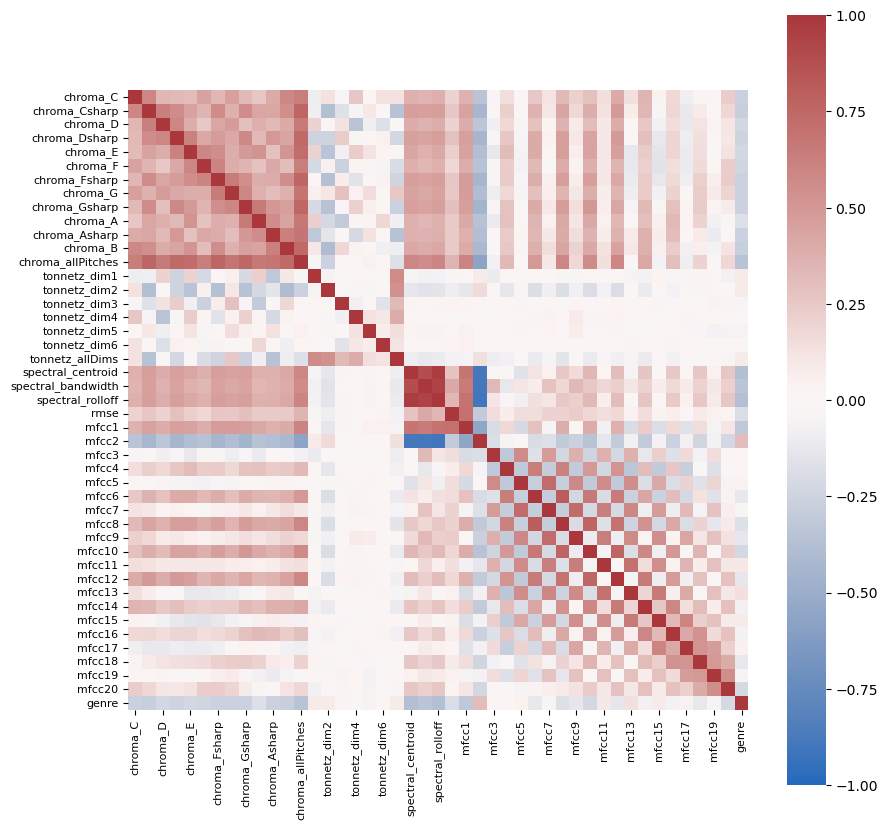

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(dfWithGenresMappedToInts.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

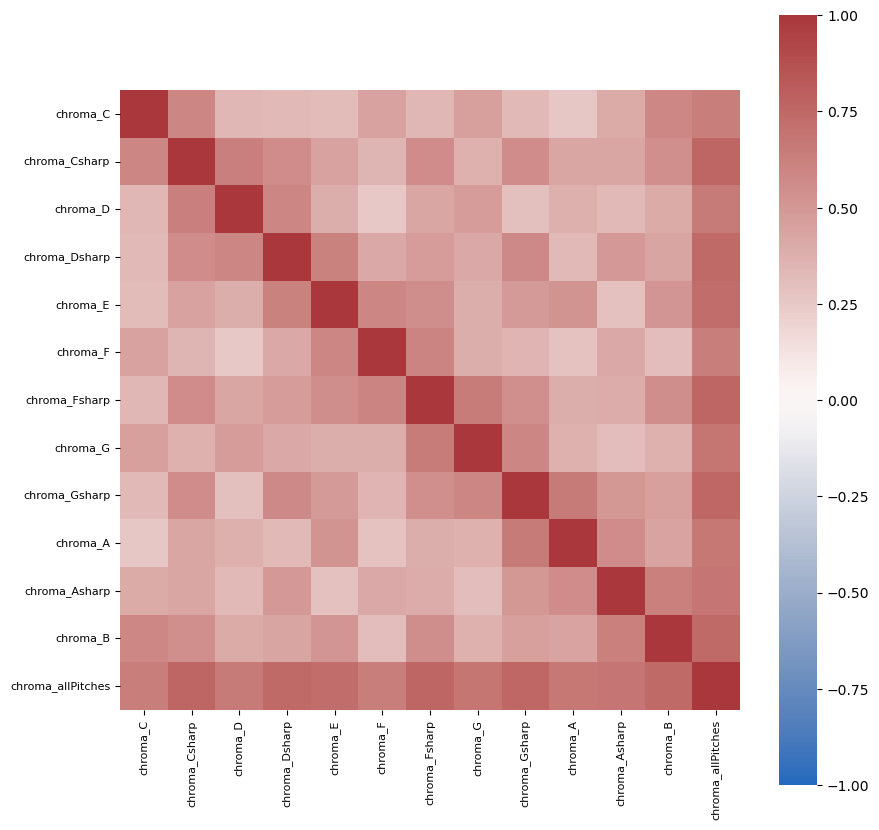

In [8]:
df_chromas = dfWithGenresMappedToInts[[col for col in dfWithGenresMappedToInts.columns if 'chroma' in col]]

plt.figure(figsize=(10,10))
sns.heatmap(df_chromas.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

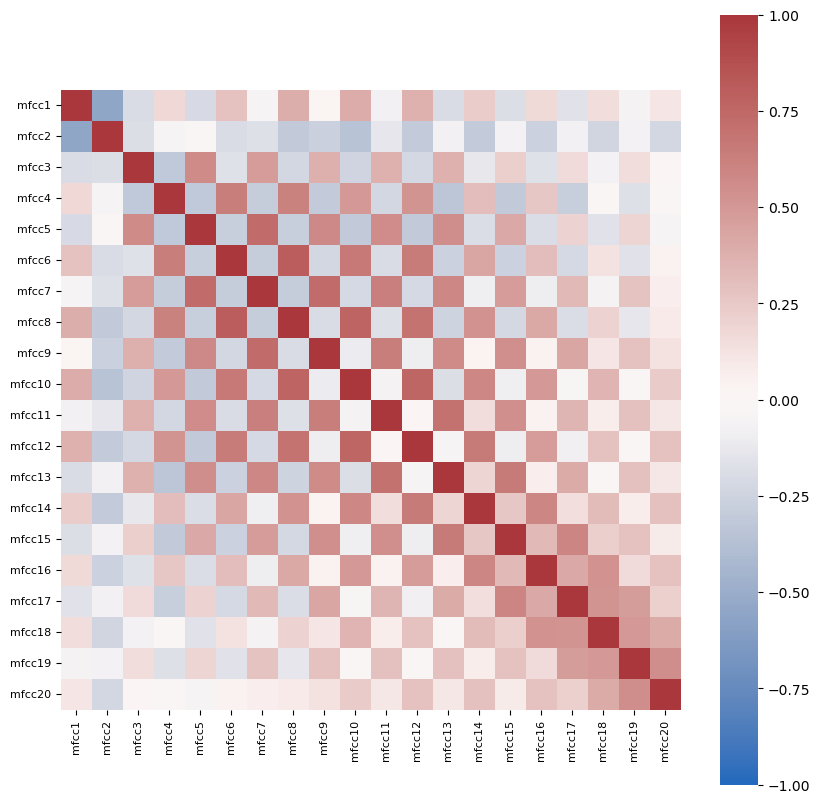

In [9]:
df_mfcc = dfWithGenresMappedToInts[[col for col in dfWithGenresMappedToInts.columns if 'mfcc' in col]]

plt.figure(figsize=(10,10))
sns.heatmap(df_mfcc.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

From the spectral features, I'll remove bandwidth and rolloff because centroids, bandwidth, and rolloff features are very highly correlated. This will reduce computational cost and makes it easy to analyze feature importance.

In [11]:
data_ = data.drop(columns=['spectral_bandwidth', 'spectral_rolloff'])

In [12]:
data_.head()

,chroma_C,chroma_Csharp,chroma_D,chroma_Dsharp,chroma_E,chroma_F,chroma_Fsharp,chroma_G,chroma_Gsharp,chroma_A,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,0.391512,0.429697,0.524729,0.385698,0.366340,0.433856,0.445597,0.593311,0.438685,0.413015,...,0.164212,2.695709,1.318642,0.632315,0.957001,-1.566437,6.275709,7.807974,6.363476,pop
1,0.544175,0.420254,0.424198,0.399732,0.300949,0.312941,0.363381,0.445987,0.342582,0.325424,...,5.130442,6.827752,3.071533,3.366904,-2.422404,-2.135466,-3.336569,-0.564991,-3.893568,pop
2,0.344232,0.477342,0.461315,0.383294,0.430534,0.360271,0.595679,0.406584,0.354102,0.464613,...,1.111607,-2.048577,-4.366745,-3.732610,-3.398216,2.417332,1.289159,7.578645,4.909898,pop
3,0.392071,0.428158,0.523789,0.385555,0.366227,0.433113,0.444056,0.591267,0.437267,0.413407,...,0.235207,2.670471,1.338333,0.699207,1.112011,-1.565463,6.195435,7.648764,6.243628,pop
4,0.396111,0.442692,0.408399,0.486187,0.353345,0.326342,0.372000,0.300399,0.334868,0.334352,...,-0.269821,-1.642580,-4.781828,-3.302547,-4.714705,-3.559506,-3.702941,-4.042264,0.333003,pop


In [14]:
mappingGenresToIntegers = {
    'pop': 0,
    'metal': 1,
    'disco': 2,
    'blues': 3,
    'reggae': 4,
    'classical': 5,
    'rock': 6,
    'hiphop': 7,
    'country': 8,
    'jazz': 9
}


dfWithGenresMappedToInts = data_.copy()
dfWithGenresMappedToInts['genre'] = dfWithGenresMappedToInts['genre'].map(mappingGenresToIntegers)

dfWithGenresMappedToInts.head()

,chroma_C,chroma_Csharp,chroma_D,chroma_Dsharp,chroma_E,chroma_F,chroma_Fsharp,chroma_G,chroma_Gsharp,chroma_A,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,0.391512,0.429697,0.524729,0.385698,0.366340,0.433856,0.445597,0.593311,0.438685,0.413015,...,0.164212,2.695709,1.318642,0.632315,0.957001,-1.566437,6.275709,7.807974,6.363476,0
1,0.544175,0.420254,0.424198,0.399732,0.300949,0.312941,0.363381,0.445987,0.342582,0.325424,...,5.130442,6.827752,3.071533,3.366904,-2.422404,-2.135466,-3.336569,-0.564991,-3.893568,0
2,0.344232,0.477342,0.461315,0.383294,0.430534,0.360271,0.595679,0.406584,0.354102,0.464613,...,1.111607,-2.048577,-4.366745,-3.732610,-3.398216,2.417332,1.289159,7.578645,4.909898,0
3,0.392071,0.428158,0.523789,0.385555,0.366227,0.433113,0.444056,0.591267,0.437267,0.413407,...,0.235207,2.670471,1.338333,0.699207,1.112011,-1.565463,6.195435,7.648764,6.243628,0
4,0.396111,0.442692,0.408399,0.486187,0.353345,0.326342,0.372000,0.300399,0.334868,0.334352,...,-0.269821,-1.642580,-4.781828,-3.302547,-4.714705,-3.559506,-3.702941,-4.042264,0.333003,0


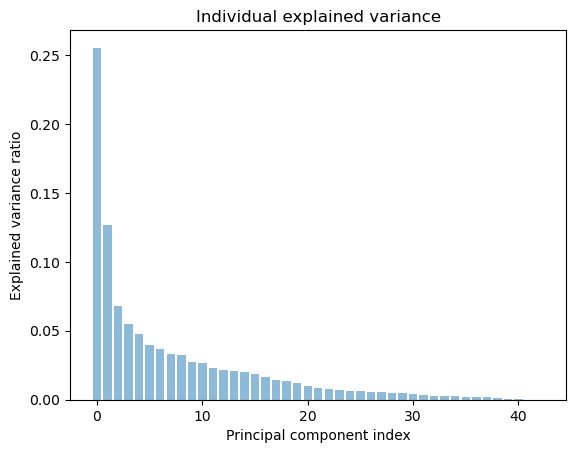

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dfWithGenresMappedToInts)

pca = PCA()
transformed = pca.fit_transform(data_scaled)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Individual explained variance")
plt.tight_layout()
plt.show()

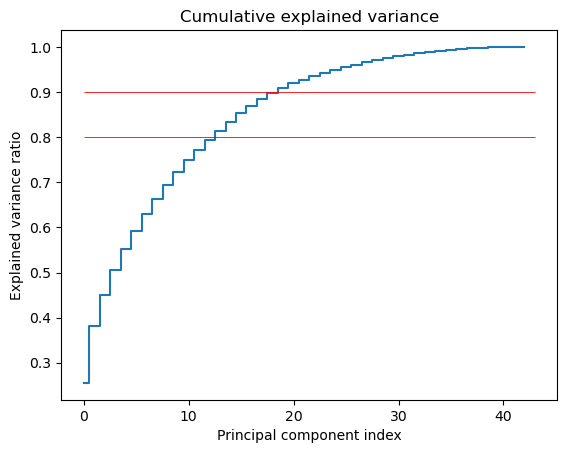

In [24]:
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.hlines(0.8, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.hlines(0.9, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Cumulative explained variance")
plt.show()

In [25]:
X_withInts = dfWithGenresMappedToInts.iloc[:, :-1]
y_withInts = dfWithGenresMappedToInts.iloc[:, -1]

X_train_withInts, X_test_withInts, y_train_withInts, y_test_withInts = train_test_split(X_withInts, y_withInts, test_size = 0.15, random_state = 42)

In [27]:
n_comps = 13
pca = PCA(n_components=n_comps)
X_train_pca_transformed = pca.fit_transform(X_train_withInts)
X_train_pca_transformed = pd.DataFrame(X_train_pca_transformed, index=X_train_withInts.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])
X_train_pca_transformed.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
643,330.838011,-28.866842,-25.744179,4.192256,-14.186220,-9.774782,1.076135,-5.035582,6.324495,2.675106,0.949918,-0.963994,0.464921
158,261.533572,-92.817843,-26.369144,12.173423,0.513937,8.728831,-2.368645,-4.197085,-0.744305,1.133299,-3.655952,1.366708,1.850958
977,880.434272,26.447275,27.502486,-10.699458,-2.063596,15.782032,3.202624,3.780341,-5.392269,-4.500167,-3.630307,-2.397736,-4.054514
429,-151.923195,59.409653,-27.294561,3.766660,-5.733211,35.223495,18.776854,-8.163333,-4.384134,9.991558,7.792787,-8.509379,-3.265278
941,-58.680086,40.418496,39.200810,5.172257,5.920961,1.594214,7.989229,7.819582,-0.459168,-5.048480,-2.566416,-0.106522,-3.404979


In [28]:
X_test_pca_transformed = pca.transform(X_test_withInts)
X_test_pca_transformed = pd.DataFrame(X_test_pca_transformed, index=X_test_withInts.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])
X_test_pca_transformed.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
521,-218.368194,58.401689,-36.275063,-18.730147,0.787034,3.169584,16.170571,5.080034,-4.007893,3.644318,6.716978,3.140190,2.789406
737,377.803096,23.440346,2.714058,-18.843700,-4.374675,17.689614,7.978006,13.181111,-1.931803,-10.340877,0.882000,-12.044210,-1.389009
740,-134.455993,-7.103448,30.642142,-15.124275,7.191016,-0.826528,7.331529,6.487387,1.191596,-12.576104,-4.153589,7.616857,0.447109
660,-5.699621,-39.476889,-46.996235,-11.617881,-2.608598,11.275776,-2.064767,-9.249274,0.107031,2.518068,1.827027,4.468149,1.397498
411,3.968591,-12.557031,15.953455,-3.560433,14.173402,2.373580,2.971312,2.060988,-6.341102,-1.406790,0.977010,-1.832939,-1.128112


In [31]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/03/e6/4aef6799badc2693548559bad5b56d56cfe89eada337c815fdfe92175250/xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.7 MB/s eta 0:00:00ta 0:00:01


In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(n_estimators=50)
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train_pca_transformed, y_train_withInts)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [37]:
print("Best parameters found:", grid_search.best_params_)

accuracy = grid_search.best_estimator_.score(X_test_pca_transformed, y_test_withInts)
print("Test Accuracy:", accuracy)

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
Test Accuracy: 0.58


In [ ]:
fig, axs = plt.subplots(10, figsize=(10,12), sharex=True)
axs[0].set_title('Confusion Matrix (XGBoost)')
axs[9].set_xlabel('Predicted labels')

for i in range(10):    
    sns.heatmap(confusion_matrix(y_true, y_pred)[i].reshape(1,-1), annot=True, cmap='gray_r',
                xticklabels=cat_y.categories, yticklabels=[cat_y.categories[i]], ax=axs[i])
plt.show()

In [ ]:
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred))
print(dict(zip(cat_y.categories, range(10))))

In [ ]:
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred))
print(dict(zip(cat_y.categories, range(10))))

In [38]:
xgb = XGBClassifier(n_estimators=50)
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search2 = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search2.fit(X_train_withInts, y_train_withInts)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [40]:
print("Best parameters found:", grid_search2.best_params_)

accuracy = grid_search2.best_estimator_.score(X_test_withInts, y_test_withInts)
print("Test Accuracy:", accuracy)

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}
Test Accuracy: 0.7


In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

xgb = XGBClassifier(n_estimators=300, colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1)
xgb.fit(X_train_withInts, y_train_withInts)

y_true = y_test_withInts.copy()
y_pred = xgb.predict(X_test_withInts)

print('XGB Accuracy: ', accuracy_score(y_test_withInts, y_pred))
print('XGB F1: ', f1_score(y_true, y_pred, average='macro'))

XGB Accuracy:  0.7
XGB F1:  0.6958340437355782


In [59]:
genres = pd.Categorical(data_.loc[:,'genre']).categories
print(genres)

Index(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal',
       'pop', 'reggae', 'rock'],
      dtype='object')


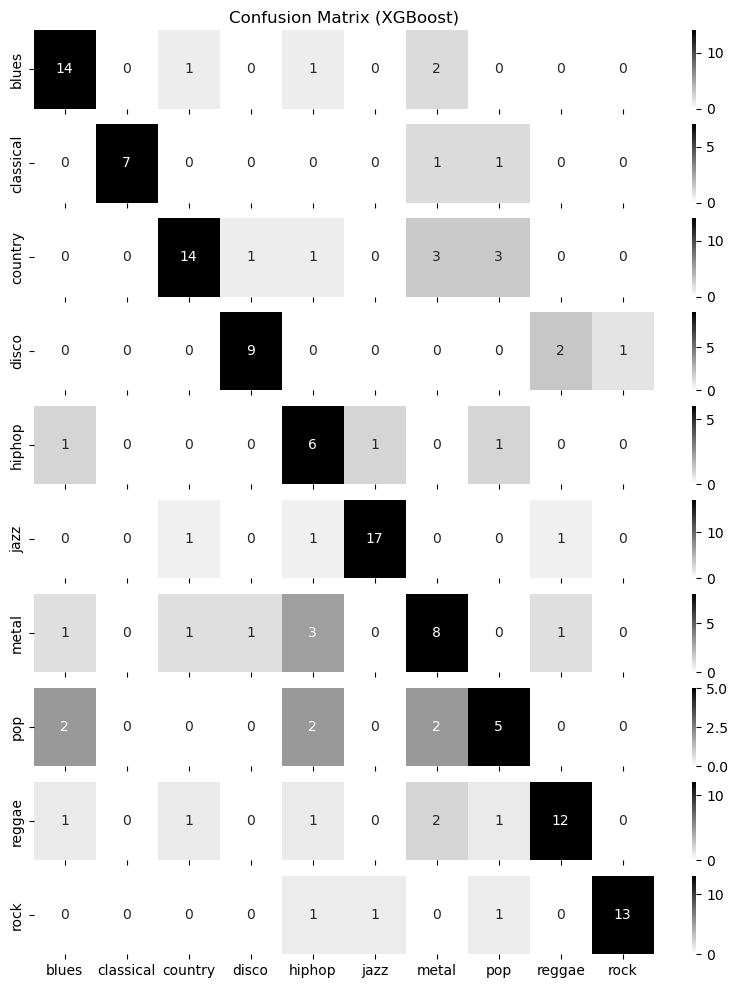

In [60]:
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(10, figsize=(10,12), sharex=True)
axs[0].set_title('Confusion Matrix (XGBoost)')
axs[9].set_xlabel('Predicted labels')

conf_mat = confusion_matrix(y_true, y_pred)

for i in range(10):    
    sns.heatmap(conf_mat[i].reshape(1,-1), annot=True, cmap='gray_r',xticklabels=genres, yticklabels=[genres[i]], ax=axs[i])
plt.show()


In [61]:
print(dict(zip(genres, range(10))))
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred))

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
XGB classification report: 

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       1.00      0.78      0.88         9
           2       0.78      0.64      0.70        22
           3       0.82      0.75      0.78        12
           4       0.38      0.67      0.48         9
           5       0.89      0.85      0.87        20
           6       0.44      0.53      0.48        15
           7       0.42      0.45      0.43        11
           8       0.75      0.67      0.71        18
           9       0.93      0.81      0.87        16

    accuracy                           0.70       150
   macro avg       0.71      0.69      0.70       150
weighted avg       0.73      0.70      0.71       150

